In [19]:
import tensorflow as tf
import importlib
import numpy as np
import os, datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
from libs.utils import LandmarkLoss
from libs.dp import Dataset
from libs.eval import parse_heatmap, l2_distance

BASE_DIR = '/media/cvmi-koo/HDD/Facial-Landmark-Detector/'
MODEL_NAME = 'test'
HM_SIZE = 64
BATCH_SIZE = 8
IMG_RES = 256
TOTAL_STEP = np.ceil(3837 / BATCH_SIZE).astype(int)
EVAL_STEP = np.ceil(600 / BATCH_SIZE).astype(int)
NUM_LANDMARKS = 68
EPOCHS = 30
lm_metric = LandmarkLoss(IMG_RES, HM_SIZE)

# Set tensorboard
current_time   = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
TB_DIR         = os.path.join(BASE_DIR, 'data', 'tensorboard', MODEL_NAME + '_' + current_time)
summary_writer = tf.summary.create_file_writer(TB_DIR)

model_path = 'tasks.model_' + MODEL_NAME
FAN = importlib.import_module(model_path).FAN(4, 256, 68)
inputs = tf.keras.Input(shape=(256, 256, 3))
outputs = FAN(inputs)
model = importlib.import_module(model_path).FacialLandmarkDetector(
    inputs=inputs, outputs=outputs, lm_metric=lm_metric, 
    hm_size=HM_SIZE, batch_size=BATCH_SIZE, train_step=TOTAL_STEP, test_step=EVAL_STEP, # summary_writer=summary_writer
)

In [6]:
eval_dataset = Dataset(IMG_RES, HM_SIZE, NUM_LANDMARKS, '../Datasets/300W/eval.csv')
eval_generator = eval_dataset.tf_eval_dataset_from_generator(BATCH_SIZE)



Train dataset: ../Datasets/300W/eval.csv
Train dataset is loaded. Shape: (600, 2)
scale: 1.0


In [7]:
for epoch in range(EPOCHS):
    model.load_weights(f'data/checkpoint/{MODEL_NAME}/cp_{epoch}.ckpt/variables/variables')
    L2_distances = []
    for inputs, labels in tqdm(eval_generator.take(EVAL_STEP), total=EVAL_STEP):
        preds = model(inputs)
        pred_kps = parse_heatmap(preds)
        L2_distance = l2_distance(pred_kps, labels)
        L2_distances.append(L2_distance)
    with summary_writer.as_default():
        tf.summary.scalar('L2_distance', np.mean(L2_distances), step=epoch)

2022-01-05 14:47:43.554827: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-05 14:47:52.270166: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2022-01-05 14:47:53.251457: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


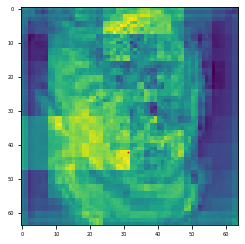

In [18]:
plt.imshow(pred[:,:,4])
plt.scatter(landmark[4][0], landmark[4][1], s=1, c='red')
plt.show()